# Quickstart :推薦システム合成シミュレーションとデータセット(離散空間)

このノートブックでは推薦システム合成データセットでのオフ方策学習(OPE)とオフライン強化学習(Offline RL)の実行例を紹介します。

推薦システムシミュレーションとデータセットの例は5つのステップから成り立っています。

0. (ベーシックな合成シミュレーション環境の設定とオンライン強化学習)
1. 合成データの生成
2. オフライン強化学習
3. オフ方策評価とオフライン強化学習手法の評価
4. オフ方策評価手法の評価

\* このライブラリは、オンラインとオフラインの方策・モデルベース評価で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています.   
\*また[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考に実装しています.

In [10]:
# import SCOPE-RL modules
import scope_rl
from recgym import RECEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicyConfig
from d3rlpy.algos import RandomPolicyConfig as ContinuousRandomPolicyConfig
from d3rlpy.preprocessing import MinMaxObservationScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch

In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# version
print(scope_rl.__version__)

0.1.2


In [5]:
# set random state
random_state = 12345

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [8]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 0. (ベーシックな合成シミュレーション環境の設定とオンライン強化学習)
まず初めに推薦システム環境を紹介します.

#### 強化学習でのベーシック環境のセットアップ
推薦システムにおいて, 強化学習エージェントの目的は累積報酬を最大化することです.

この問題を(部分観測)マルコフ決定過程((PO)MDP)として定式化します.
- `状態`: 
   - ユーザーの好みを表すベクトル. 好みはRLエージェントが提示する行動によってエピソードの中で時間と共に変化する.
   - 真の状態が観測できない場合, エージェントは状態の代わりに観測を用いる.
- `行動`: どのアイテムをユーザに提示するかを表す.
- `報酬`: ユーザーの関連シグナル. binary または continuous.


より詳細に環境の引数を確認したい場合は、次のノートブックを参照してください. [examples/quickstart/rec/rec_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_customize_env.ipynb).

In [9]:
# setup environment
env = gym.make('RECEnv-v0')

In [11]:
# define a random agent
agent = OnlineHead(
    DiscreteRandomPolicyConfig().create(device=device),
    name="random",
)
agent.build_with_env(env)

In [12]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [13]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.13726447  0.0194582   0.10000844 -0.04762143  0.09446818]


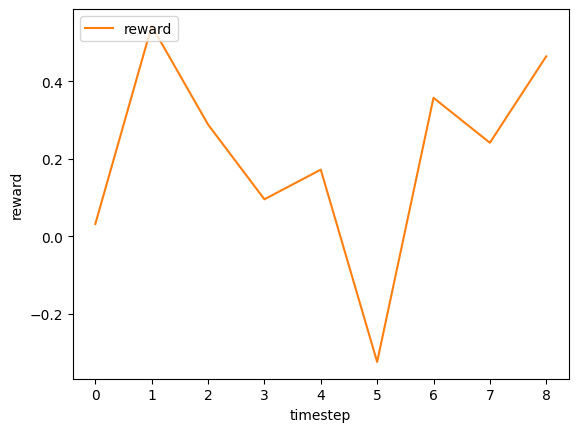

In [14]:
# let's visualize the transition of reward
obs, info = env.reset()
done = False
reward_list = []

while not done:
    action = agent.sample_action_online(obs)

    obs, reward, done, truncated, info = env.step(action)
    reward_list.append(reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward')
ax1.legend(loc='upper left')
plt.show()

For more about the environmental configurations and customization, please refer to [examples/quickstart/rec/rec_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to the random policy, using on-policy policy estimation.

In [15]:
# standardized environment for discrete action
env = RECEnv(random_state=random_state)

In [16]:
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# replay buffer
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=50000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [18]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [19]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-07-22 17:54:09 [warning  ] Parameters will be reinitialized.


Text(0, 0.5, 'episode reward')

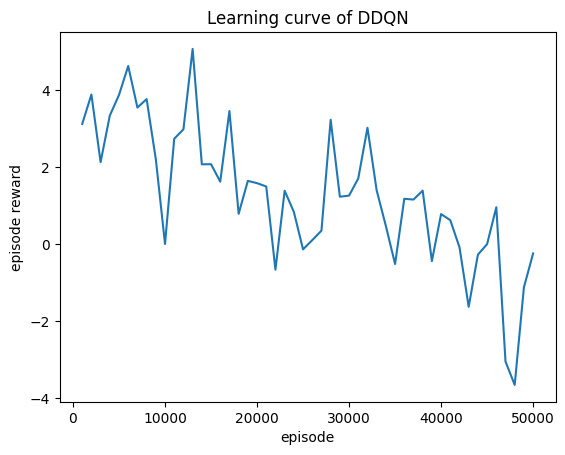

In [20]:
# we see that training RL policy can be risky online
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [23]:
random = DiscreteRandomPolicyConfig().create(device=device)
random.build_with_env(env)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

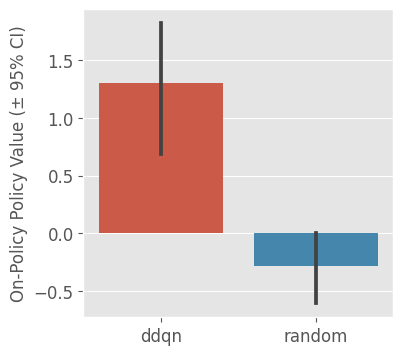

In [24]:
# compare the policy performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [25]:
# on-policy policy value by ddqn policy
# largely outperforms the random policy (about 20%)
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("improvement:", ddqn_performance - random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

improvement: 1.558461332832902


Note that, we provide the following functions for online evaluation of the policy performance under `scope_rl.ope.online`.

(Statistics)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(Visualization)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact with the environment *online* using synthetic simulator.  
Though simulation is a good starting point for training an agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in the real-world.
Therefore, we introduce an alternative learning protocol, Offline RL, which aims at training a new policy using only offline logged dataset collected by a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

We prepare an easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding the simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use a real-world dataset, please see #TODO (will be implemented).

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

In [26]:
# import necessary module from SCOPE-RL
from scope_rl.policy import EpsilonGreedyHead

In [27]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [28]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [30]:
train_logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 5,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[ 0.04479014,  0.11492637, -0.05131316, -0.0280654 ,  0.0347718 ],
        [ 0.39224767,  0.80005173, -0.28628983, -0.17037224,  0.30833493],
        [ 0.42240998,  0.78247161, -0.15893681, -0.18787797,  0.38567985],
        ...,
        [-0.4762458 , -0.61565697,  0.34349606, -0.11468651, -0.51284881],
        [-0.42601396, -0.52915466,  0.40759172, -0.03914639, -0.60896962],
        [-0.47442487, -0.57688529,  0.31635916, -0.01311537, -0.58469588]]),
 'action': array([0, 1, 2, ..., 2, 0, 2]),
 'reward': array([-0.07510555, -0.34569477,  0.11200114, ..., -0.20323486,
         0.54777489, -0.28543168]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.76, 0.06, 0.76, ...

In [29]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [31]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

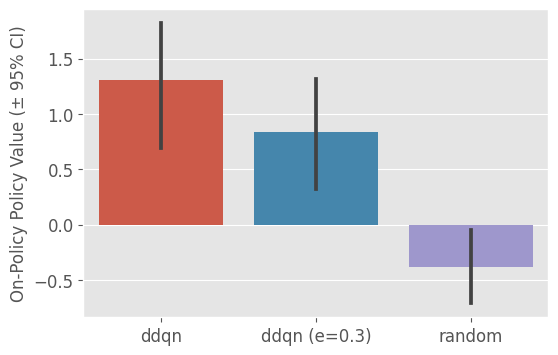

In [32]:
# compare the policy performance online
# almost the same performance as greedy ddqn
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

For more about the data collection and visualization, please refer to [examples/quickstart/rec/rec_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [33]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig

In [34]:
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [35]:
# Use Conservative Q-Learning policy
cql = DiscreteCQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [37]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [39]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

2023-07-22 18:02:19 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

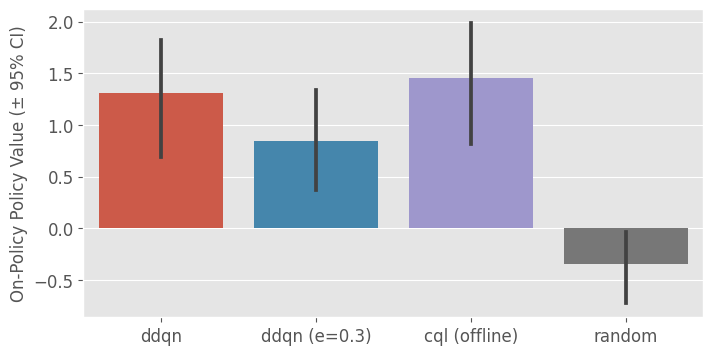

In [40]:
# compare the policy performance online
# not better than online policy, but achieves almost the same performance
# meaning that we can learn a reasonable policy without interacting with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of a learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim at evaluating the performance of a policy offline, to gain some prior knowledge on how agent works in the environment.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [47]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [48]:
# define evaluation policies
cql_ = EpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = EpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = EpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [43]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        }
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [44]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-07-22 18:02:40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-07-22 18:02:40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230722180240
2023-07-22 18:02:40 [debug    ] Building models...
2023-07-22 18:02:40 [debug    ] Models have been built.
2023-07-22 18:02:40 [info     ] Parameters                     params={'observation_shape': [5], 'action_size': 5, 'config': {'type': 'fqe', 'params': {'batch_size': 100, 'gamma': 1.0, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 0.0001, 'optim_factory': {'type': 'adam', 'params': {'betas': [0.9, 0.999], 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-07-22 18:03:05 [info     ] DiscreteFQE_20230722180240: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010205008745193481, 'time_algorithm_update': 0.0013656225442886354, 'loss': 7.594922496168316, 'time_step': 0.002461224675178528} step=10000
2023-07-22 18:03:05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230722180240/model_10000.d3
2023-07-22 18:03:05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-07-22 18:03:05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230722180305
2023-07-22 18:03:05 [debug    ] Building models...
2023-07-22 18:03:05 [debug    ] Models have been built.
2023-07-22 18:03:05 [info     ] Parameters                     params={

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-07-22 18:03:27 [info     ] DiscreteFQE_20230722180305: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009497817993164063, 'time_algorithm_update': 0.0011848777770996095, 'loss': 11.54115076702088, 'time_step': 0.0021957416772842406} step=10000
2023-07-22 18:03:27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230722180305/model_10000.d3
2023-07-22 18:03:27 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(5,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float64')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=5)
2023-07-22 18:03:27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230722180327
2023-07-22 18:03:27 [debug    ] Building models...
2023-07-22 18:03:27 [debug    ] Models have been built.
2023-07-22 18:03:27 [info     ] Parameters                     params=

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-07-22 18:03:47 [info     ] DiscreteFQE_20230722180327: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009308305501937866, 'time_algorithm_update': 0.0009925251245498658, 'loss': 0.12489210550989956, 'time_step': 0.0019779507160186767} step=10000
2023-07-22 18:03:47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230722180327/model_10000.d3


[collect input data: eval_policy]:   0%|          | 0/3 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [46]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [49]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [50]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [51]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy      1.449920               1.000000
 dm            96.903349              66.833598
 tis            1.884254               1.299557
 pdis           1.605809               1.107516
 dr             7.478347               5.157766
 sntis          3.176659               2.190921
 snpdis         1.948656               1.343975
 sndr         -66.216513             -45.669091,
 'ddqn':            policy_value  relative_policy_value
 on_policy      1.305555               1.000000
 dm           174.810128             133.897198
 tis            1.261084               0.965937
 pdis           1.236058               0.946769
 dr             3.499134               2.680189
 sntis          1.247288               0.955370
 snpdis         1.216990               0.932163
 sndr           5.413034               4.146156,
 'random':            policy_value  relative_policy_value
 on_policy     -0.475200                    NaN
 dm          

In [52]:
# estimated confidence intervals of the policy performance
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy   1.469558          0.914655          1.948925
 dm         96.903537         96.483361         97.379692
 tis         1.889711          1.699092          2.137394
 pdis        1.600044          1.498639          1.716463
 dr          7.134107         -9.241690         18.468379
 sntis       3.185859          2.864494          3.603426
 snpdis      1.942285          1.814173          2.078125
 sndr      -66.653928        -94.938943        -48.145270,
 'ddqn':                  mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy    1.334626          0.799851          1.832369
 dm         174.814123        174.228089        175.471843
 tis          1.269711          1.056423          1.504950
 pdis         1.226794          1.115625          1.331387
 dr           1.623300        -25.687265         22.654888
 sntis        1.255820          1.044866          1.488485
 snpdis       1.207907          1.099196         

## 4. Evaluation of OPE methods
Now, we evaluate how well the ope estimators estimated the policy value.

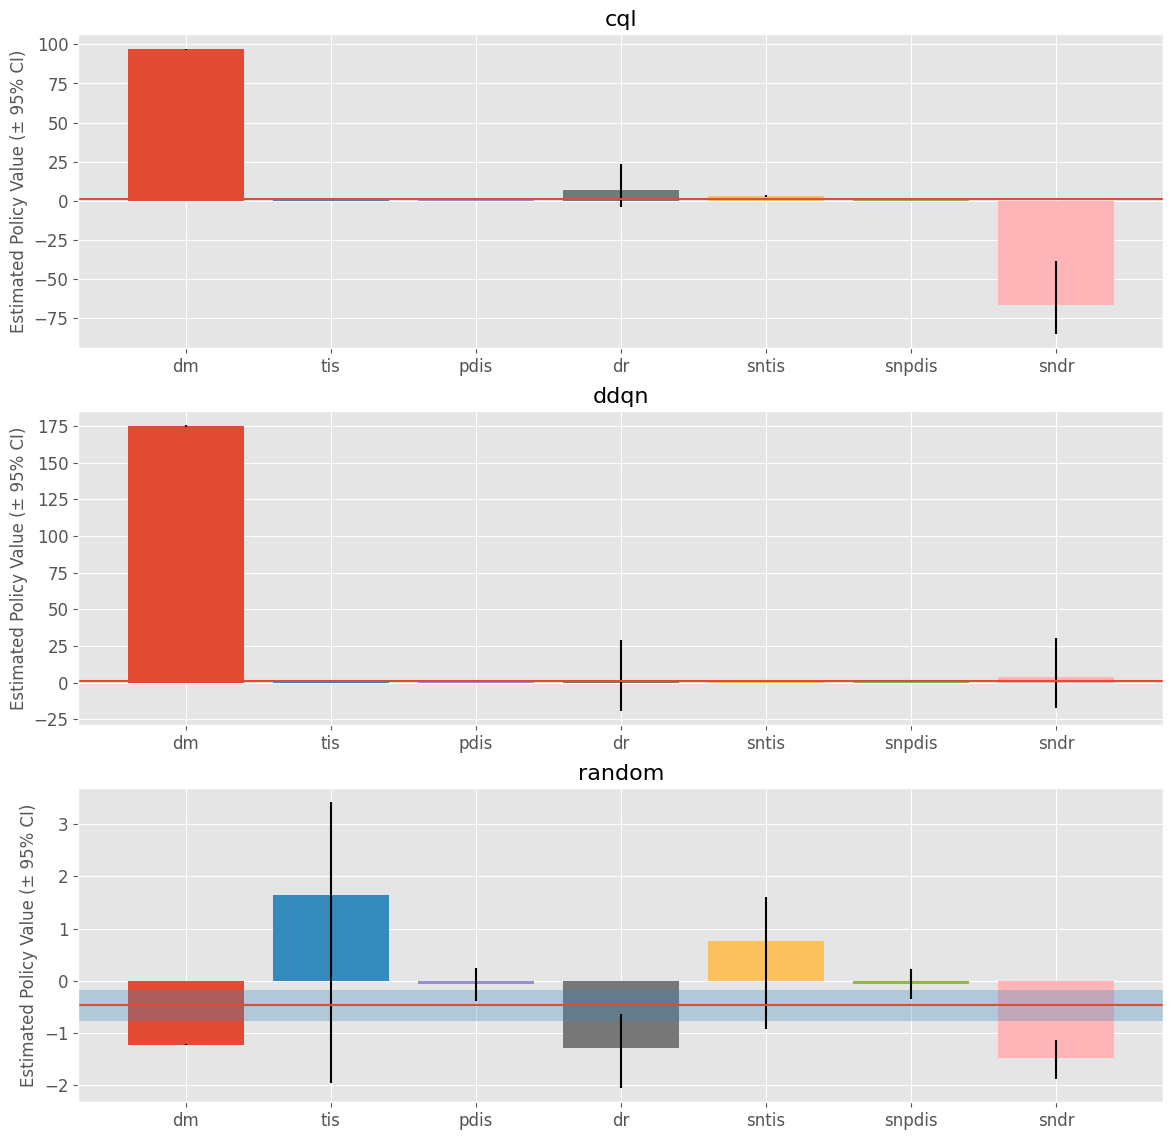

In [53]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while (trajectory-wise) importance sampling estimators have a smaller bias with a larger variance.
# self-normalized estimators also works well
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [54]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,ddqn,random
dm,9111.357085,30103.836849,0.570325
tis,0.188646,0.001978,4.297308
pdis,0.024301,0.004830,0.176675
dr,36.341932,4.811791,0.669424
sntis,2.981628,0.003395,1.501802
snpdis,0.248738,0.007844,0.180809
sndr,4578.746132,16.871384,1.022200


For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rec/rec_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_discrete_advanced.ipynb). 

For more advanced OPE estimators (e.g., state(-action) marginal estimators and double reinforcement learning), please refer to [examples/quickstart/rec/rec_synthetic_discrete_zoo.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_discrete_zoo.ipynb). 

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.